In [29]:
import torch.optim as optim
import pandas as pd
from sklearn.metrics import accuracy_score
from helper_DinoV2_Embeddings import *
from helper_classifier import prepare_data, get_datasets, train_model, evaluate_model, train_wb, set_seed
from helper_classifier import DressCategoriesDataset, ClassifierModel

set_seed(42)
root_path = f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/images/square_images/"

In [30]:
target_feature = 'category'
retrain = False

In [31]:
embeddings, df = extract_embeddings()
df, id2label, label2id = prepare_data(df, target_feature)
train_dataset, test_dataset = get_datasets(df, embeddings)

Loading embeddings from disk...
14060 embeddings loaded from disk...


In [32]:
generated_embeddings, generated_df = extract_generated_embeddings()
generated_df, generated_id2label, generated_label2id = prepare_data(generated_df, target_feature)
generated_train_dataset, generated_test_dataset = get_datasets(generated_df, generated_embeddings)

Loading embeddings from disk...
14060 embeddings loaded from disk...


In [33]:
id2label == generated_id2label

True

In [34]:
# concat datasets
train_dataset = torch.utils.data.ConcatDataset([train_dataset, generated_train_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_dataset, generated_test_dataset])

In [35]:
print(f"Number of classes: {len(id2label)}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of classes: 8
Number of training samples: 22496
Number of testing samples: 5624


### Train with best hyperparamaters

In [36]:
NUM_EPOCHS = 10
BATCH_SIZE = 32
LR = 0.001
optimizer_name = 'adamw'

dino_device, sg2_device, device = set_device()

loss_fn = nn.CrossEntropyLoss()
model = ClassifierModel(embeddings.shape[1], len(label2id)).to(device)

if optimizer_name == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=LR)
elif optimizer_name == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=LR)
elif optimizer_name == 'sgd':
    optimizer =  optim.SGD(model.parameters(), lr=LR, momentum=0.9)

save_path = f"{DATA_PATH}/Models/Assessor/DinoV2/Classifier/dinov2_{target_feature}_classifier_with_generated.pt"
if not os.path.exists(save_path) or retrain:
    train_model(model, NUM_EPOCHS, BATCH_SIZE, optimizer, loss_fn, train_dataset, test_dataset, save_path, device)

Using devices: DinoV2 device: cuda | SG2 device: cuda | General device: cuda


### Check Model Performance

In [37]:
model = torch.load(save_path)
model = model.to(device)

In [38]:
train_acc = evaluate_model(model, DataLoader(train_dataset, batch_size=32, shuffle=False), device)
test_acc = evaluate_model(model, DataLoader(test_dataset, batch_size=32, shuffle=False), device)
print(f"Train Accuracy: {np.round(train_acc*100, 2)}%, Test Accuracy: {np.round(test_acc*100, 2)}%")

Train Accuracy: 72.87%, Test Accuracy: 61.29%


### 1. On Real Images

In [39]:
for i in tqdm(df.index, total=len(df.index)):
    embedding = embeddings[i,:]
    embedding = embedding.to(device)
    label = df.loc[i]['label']
    with torch.no_grad():
        output = model(embedding)
        prob, predicted = torch.max(softmax(output.data, 0), 0)
        df.loc[i, 'predicted_label'] = predicted.item()
        df.loc[i, 'predicted_prob'] = prob.item()

df['predicted_category'] = df.predicted_label.map(id2label)
overall_accuracy = accuracy_score(df['label'], df['predicted_label'])
print(f"Overall Accuracy: {overall_accuracy:.2%}")

  0%|          | 0/14060 [00:00<?, ?it/s]

Overall Accuracy: 79.57%


In [40]:
# Function to calculate accuracy for a group
def group_accuracy(group):
    return accuracy_score(group['label'], group['predicted_label'])

# Calculate accuracy for each category
group_accuracy = df.groupby(target_feature).apply(group_accuracy).sort_values(ascending=False)

# Print the accuracy for each category
print("Accuracy by Group:")
print(group_accuracy)

Accuracy by Group:
category
Denim dress                     0.967949
Jumper dress                    0.925591
Occasion wear                   0.858017
Day dress                       0.823125
Maxi dress                      0.779362
Cocktail dress / Party dress    0.740091
Jersey dress                    0.684916
Shift dress                     0.517857
dtype: float64


/scratch/slurm_tmpdir/job_23536517/ipykernel_141224/1847911324.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_accuracy = df.groupby(target_feature).apply(group_accuracy).sort_values(ascending=False)


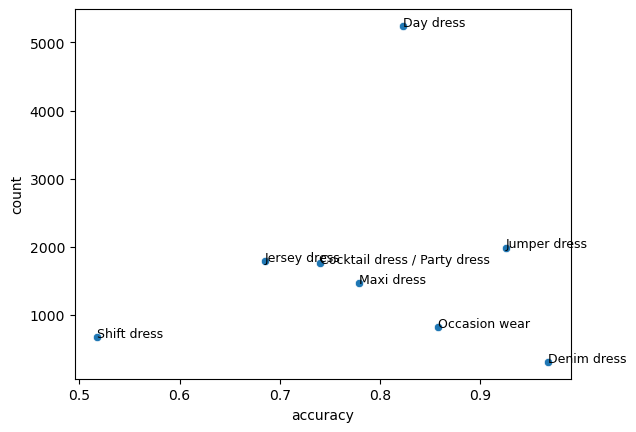

In [41]:
plot_data = pd.DataFrame(group_accuracy).reset_index().rename(columns={0: 'accuracy'}).merge(df[target_feature].value_counts().reset_index())
# Plot accuracy against number of samples and name each dot
plt.figure()
import seaborn as sns
sns.scatterplot(data=plot_data, x='accuracy', y='count')
for i in range(plot_data.shape[0]):
    plt.text(plot_data.accuracy[i], plot_data['count'][i], plot_data[target_feature][i], fontsize=9)

In [42]:
# Print confusion matrix
confusion_matrix = pd.crosstab(df['predicted_category'], df[target_feature], rownames=['Predicted'], colnames=['Actual'])
confusion_matrix

Actual,Cocktail dress / Party dress,Day dress,Denim dress,Jersey dress,Jumper dress,Maxi dress,Occasion wear,Shift dress
Predicted,,,,,,,,
Cocktail dress / Party dress,1307,124,0,36,8,8,27,62
Day dress,207,4314,8,292,37,205,9,61
Denim dress,0,9,302,0,0,2,0,0
Jersey dress,41,299,0,1226,92,40,8,96
Jumper dress,38,124,1,113,1841,30,5,97
Maxi dress,62,339,0,83,9,1148,66,7
Occasion wear,83,9,0,14,0,38,701,1
Shift dress,28,23,1,26,2,2,1,348


### 2. On generated Images

In [43]:
for i in tqdm(generated_df.index, total=len(generated_df.index)):
    embedding = generated_embeddings[i,:]
    embedding = embedding.to(device)
    label = generated_df.loc[i]['label']
    with torch.no_grad():
        output = model(embedding)
        prob, predicted = torch.max(softmax(output.data, 0), 0)
        generated_df.loc[i, 'predicted_label'] = predicted.item()
        generated_df.loc[i, 'predicted_prob'] = prob.item()

generated_df['predicted_category'] = generated_df.predicted_label.map(id2label)
overall_accuracy = accuracy_score(generated_df['label'], generated_df['predicted_label'])
print(f"Overall Accuracy: {overall_accuracy:.2%}")

  0%|          | 0/14060 [00:00<?, ?it/s]

Overall Accuracy: 61.54%


In [44]:
# Function to calculate accuracy for a group
def group_accuracy(group):
    return accuracy_score(group['label'], group['predicted_label'])

# Calculate accuracy for each category
group_accuracy = generated_df.groupby(target_feature).apply(group_accuracy).sort_values(ascending=False)

# Print the accuracy for each category
print("Accuracy by Group:")
print(group_accuracy)

Accuracy by Group:
category
Jumper dress                    0.797386
Day dress                       0.772562
Occasion wear                   0.757650
Denim dress                     0.727564
Maxi dress                      0.638153
Cocktail dress / Party dress    0.321065
Jersey dress                    0.285475
Shift dress                     0.227679
dtype: float64


/scratch/slurm_tmpdir/job_23536517/ipykernel_141224/3844287303.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_accuracy = generated_df.groupby(target_feature).apply(group_accuracy).sort_values(ascending=False)


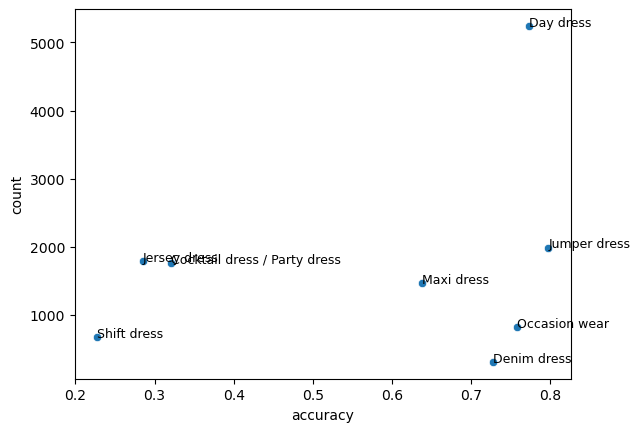

In [45]:
plot_data = pd.DataFrame(group_accuracy).reset_index().rename(columns={0: 'accuracy'}).merge(generated_df[target_feature].value_counts().reset_index())
# Plot accuracy against number of samples and name each dot
plt.figure()
import seaborn as sns
sns.scatterplot(data=plot_data, x='accuracy', y='count')
for i in range(plot_data.shape[0]):
    plt.text(plot_data.accuracy[i], plot_data['count'][i], plot_data[target_feature][i], fontsize=9)

### Deep Dive Misclassified Samples

SKU: KRG21C02R-I11


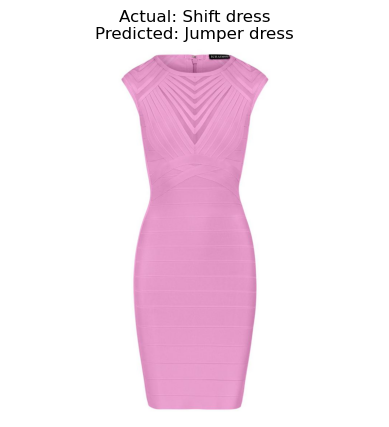

In [46]:
# Lets see some misclassified examples
misclassified = df[df['label'] != df['predicted_label']]
misclassified = misclassified.sample(1)
for i, row in misclassified.iterrows():
    print(f"SKU: {row['sku']}")
    img_path = f"{root_path}/{row['sku']}.jpg"
    img = Image.open(img_path)
    plt.figure()
    plt.imshow(img)
    plt.title(f"Actual: {row[target_feature]}\nPredicted: {row['predicted_category']}")
    plt.axis('off')

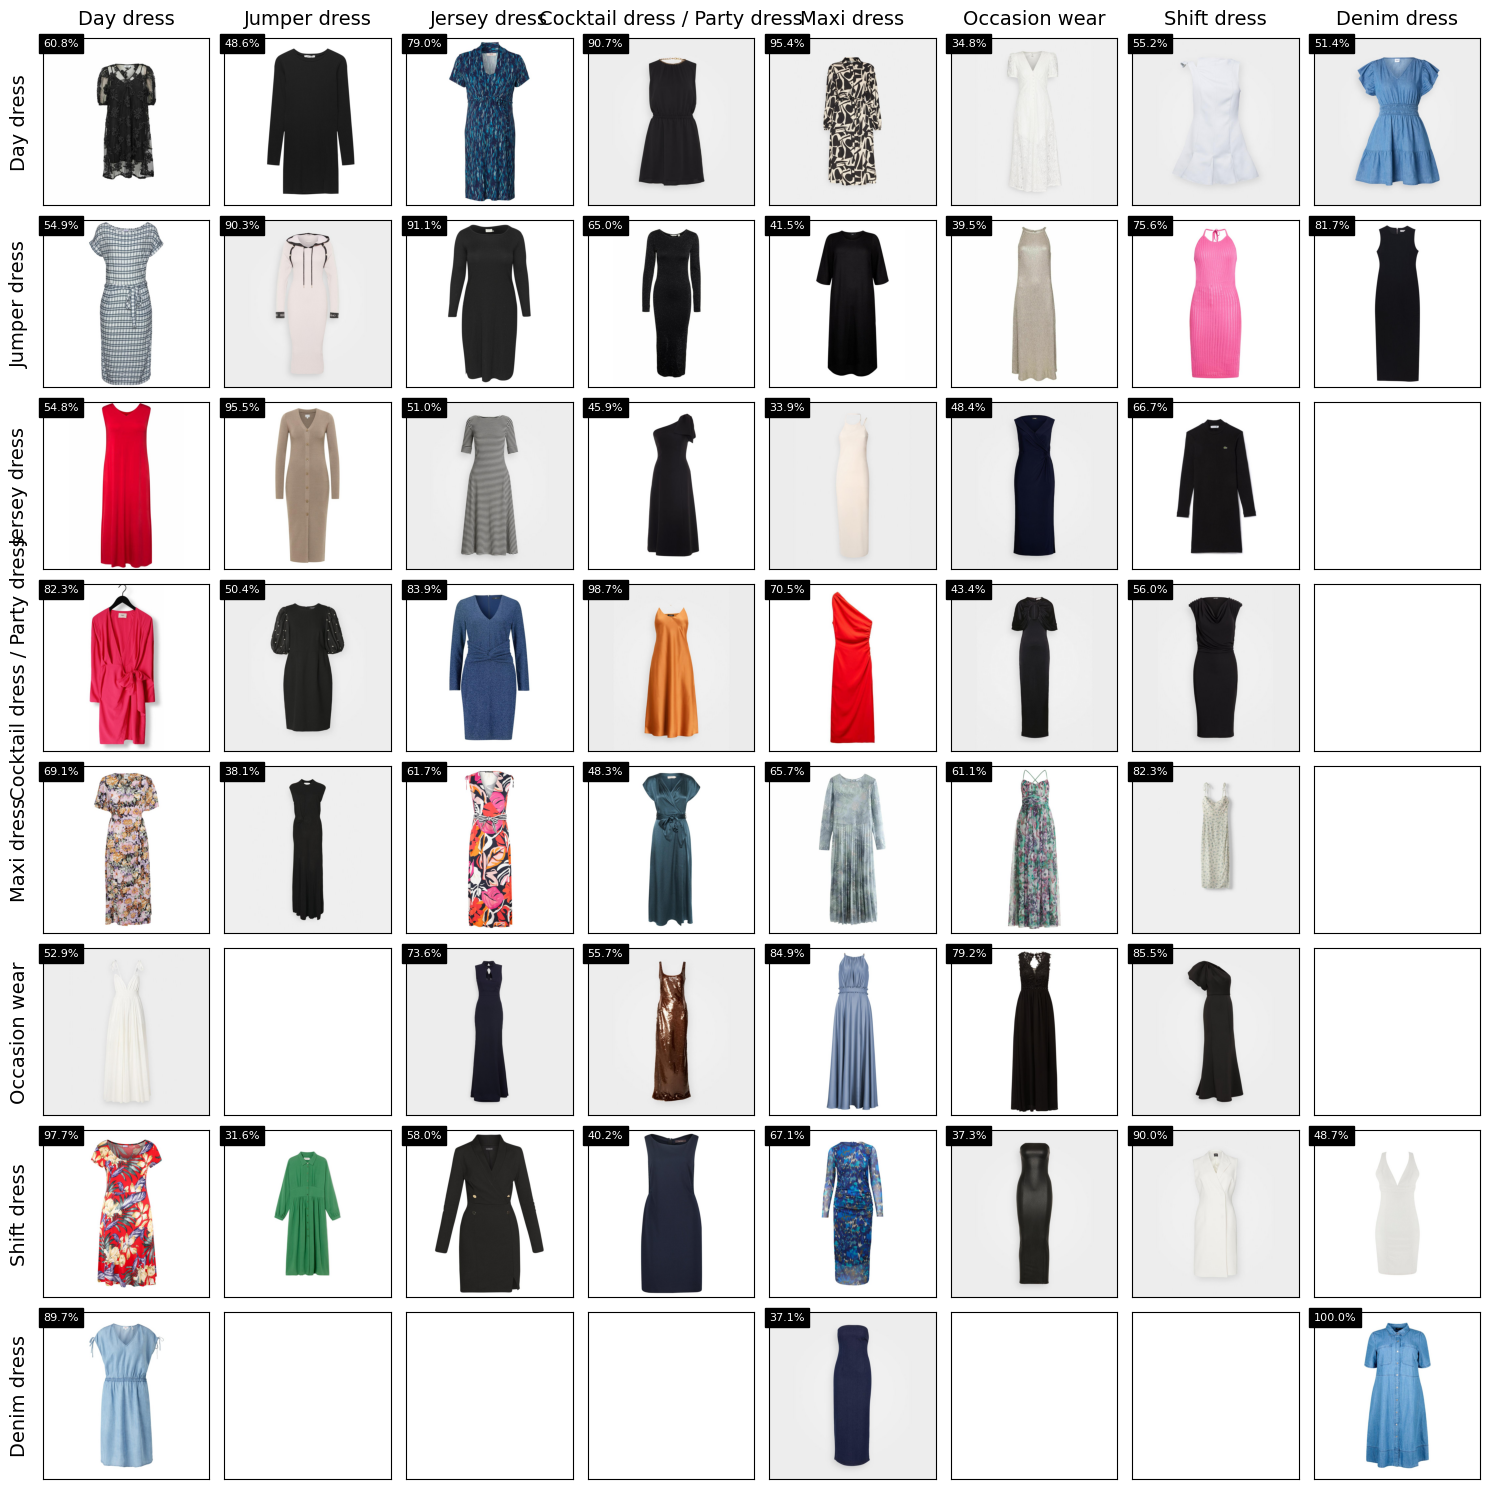

In [47]:
# Actual labels in the columns, predicted labels in the rows
root_path = f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/images/square_images/"
fig, axs = plt.subplots(len(id2label), len(id2label), figsize=(15, 15))

for i in range(len(id2label)): 
    for j in range(len(id2label)): 
        subset = df[(df['label'] == i) & (df['predicted_label'] == j)]
        if not subset.empty:
            sample = subset.sample(1)
            img_path = f"{root_path}{sample['sku'].item()}.jpg"
            img = Image.open(img_path)
            axs[j, i].imshow(img)
            axs[j, i].text(0, 0, f'{np.round(sample.predicted_prob.item()*100,1)}%', color='white', backgroundcolor='black', fontsize=8, verticalalignment='top')
        #axs[j, i].axis('off')
        axs[j, i].set_xticks([])  # Ensure no ticks
        axs[j, i].set_yticks([])
        axs[j, 0].set_ylabel(id2label[j], labelpad=10, fontsize=14)


    # Set labels with a larger font and some padding for better visibility
    axs[0, i].set_title(id2label[i], pad=10, fontsize=14)
    



plt.tight_layout()
plt.show()


### Top N Accuracy

Check the performance of the model if one uses the top N predicted classes as prediction. This might accomodate to the overalpping classes seen in the dataset

### 1. On Real Images

In [48]:
n = 3

df_topn = df[['sku', target_feature, 'label']].copy()
# Separate between test and train set
df_topn.loc[train_dataset.datasets[0].df.index_id, 'dataset'] = 'train'
df_topn.loc[test_dataset.datasets[0].df.index_id, 'dataset'] = 'test'
# Make top n predictions
for i in tqdm(df_topn.index, total=len(df.index)):
    embedding = embeddings[i,:]
    embedding = embedding.to(device)
    label = df_topn.loc[i]['label']
    with torch.no_grad():
        output = model(embedding)
        prob, predicted = torch.topk(torch.softmax(output, 0), n)
        for j in range(n):
            df_topn.loc[i, f'predicted_label_{j+1}'] = predicted[j].item()
            df_topn.loc[i, f'predicted_prob_{j+1}'] = prob[j].item()

for i in range(n):
    df_topn[f'predicted_category_{i+1}'] = df_topn[f'predicted_label_{i+1}'].map(id2label)

  0%|          | 0/14060 [00:00<?, ?it/s]

In [49]:
def isin_first_n(row, n):
    label = row['label']
    preds = row[[f'predicted_label_{i+1}' for i in range(n)]].values
    return label in preds

df_topn['isin_top1'] = df_topn.apply(lambda x: isin_first_n(x, 1), axis=1)
df_topn['isin_top2'] = df_topn.apply(lambda x: isin_first_n(x, 2), axis=1)
df_topn['isin_top3'] = df_topn.apply(lambda x: isin_first_n(x, 3), axis=1)

for i in range(1,n+1):
    print(f"Top {i} Accuracy: {df_topn[f'isin_top{i}'].mean():.2%}")

Top 1 Accuracy: 79.57%
Top 2 Accuracy: 94.01%
Top 3 Accuracy: 98.10%


In [50]:
# Separate between test and train set for accuracy calculation
for set in ['train', 'test']:
    print(f"\nAccuracy for {set} set:")
    for i in range(1,n+1):
        print(f"Top {i} Accuracy: {df_topn[df_topn['dataset'] == set][f'isin_top{i}'].mean():.2%}")


Accuracy for train set:
Top 1 Accuracy: 82.41%
Top 2 Accuracy: 95.54%
Top 3 Accuracy: 98.80%

Accuracy for test set:
Top 1 Accuracy: 68.17%
Top 2 Accuracy: 87.91%
Top 3 Accuracy: 95.31%


In [51]:
# Per category accuracy for top n
for i in range(1,n):
    print(f"\nTop {i} Accuracy by Group:")
    group_accuracy = df_topn.groupby(target_feature).apply(lambda x: x[f'isin_top{i}'].mean()).sort_values(ascending=False)
    print(group_accuracy)


Top 1 Accuracy by Group:
category
Denim dress                     0.967949
Jumper dress                    0.925591
Occasion wear                   0.858017
Day dress                       0.823125
Maxi dress                      0.779362
Cocktail dress / Party dress    0.740091
Jersey dress                    0.684916
Shift dress                     0.517857
dtype: float64

Top 2 Accuracy by Group:
category
Denim dress                     0.990385
Day dress                       0.973288
Jumper dress                    0.972851
Occasion wear                   0.954712
Maxi dress                      0.947726
Jersey dress                    0.907263
Cocktail dress / Party dress    0.887882
Shift dress                     0.751488
dtype: float64


/scratch/slurm_tmpdir/job_23536517/ipykernel_141224/3485576233.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_accuracy = df_topn.groupby(target_feature).apply(lambda x: x[f'isin_top{i}'].mean()).sort_values(ascending=False)
/scratch/slurm_tmpdir/job_23536517/ipykernel_141224/3485576233.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_accuracy = df_topn.groupby(target_feature).apply(lambd

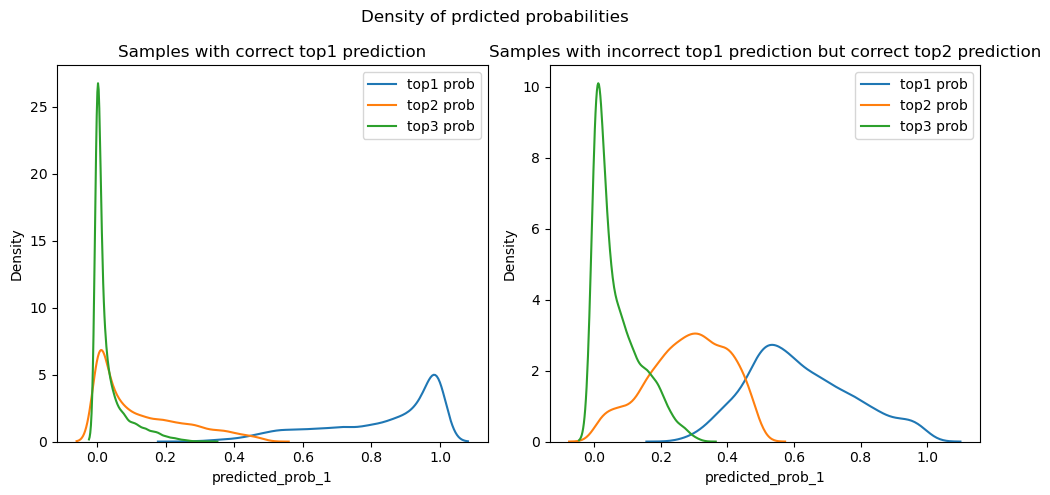

In [52]:
import seaborn as sns 
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(df_topn[df_topn.isin_top1 == True].predicted_prob_1, label='top1 prob', ax = ax[0])
sns.kdeplot(df_topn[df_topn.isin_top1 == True].predicted_prob_2, label='top2 prob', ax = ax[0])
sns.kdeplot(df_topn[df_topn.isin_top1 == True].predicted_prob_3, label='top3 prob', ax = ax[0])

sns.kdeplot(df_topn[(df_topn.isin_top1 == False) & (df_topn.isin_top2 == True)].predicted_prob_1, label='top1 prob', ax = ax[1])
sns.kdeplot(df_topn[(df_topn.isin_top1 == False) & (df_topn.isin_top2 == True)].predicted_prob_2, label='top2 prob', ax = ax[1])
sns.kdeplot(df_topn[(df_topn.isin_top1 == False) & (df_topn.isin_top2 == True)].predicted_prob_3, label='top3 prob', ax = ax[1])

ax[0].set_title('Samples with correct top1 prediction')
ax[1].set_title('Samples with incorrect top1 prediction but correct top2 prediction')

ax[0].legend()
ax[1].legend()
 
fig.suptitle('Density of prdicted probabilities')
plt.tight_layout()
plt.show()

### 2. On Generated Images

In [53]:
n = 3

generated_df_topn = generated_df[['sku', target_feature, 'label']].copy()
# Separate between test and train set
generated_df_topn.loc[train_dataset.datasets[1].df.index_id, 'dataset'] = 'train'
generated_df_topn.loc[test_dataset.datasets[1].df.index_id, 'dataset'] = 'test'
# Make top n predictions
for i in tqdm(generated_df_topn.index, total=len(generated_df.index)):
    embedding = generated_embeddings[i,:]
    embedding = embedding.to(device)
    label = generated_df_topn.loc[i]['label']
    with torch.no_grad():
        output = model(embedding)
        prob, predicted = torch.topk(torch.softmax(output, 0), n)
        for j in range(n):
            generated_df_topn.loc[i, f'predicted_label_{j+1}'] = predicted[j].item()
            generated_df_topn.loc[i, f'predicted_prob_{j+1}'] = prob[j].item()

for i in range(n):
    generated_df_topn[f'predicted_category_{i+1}'] = generated_df_topn[f'predicted_label_{i+1}'].map(id2label)

  0%|          | 0/14060 [00:00<?, ?it/s]

In [54]:
def isin_first_n(row, n):
    label = row['label']
    preds = row[[f'predicted_label_{i+1}' for i in range(n)]].values
    return label in preds

generated_df_topn['isin_top1'] = generated_df_topn.apply(lambda x: isin_first_n(x, 1), axis=1)
generated_df_topn['isin_top2'] = generated_df_topn.apply(lambda x: isin_first_n(x, 2), axis=1)
generated_df_topn['isin_top3'] = generated_df_topn.apply(lambda x: isin_first_n(x, 3), axis=1)

for i in range(1,n+1):
    print(f"Top {i} Accuracy: {generated_df_topn[f'isin_top{i}'].mean():.2%}")

Top 1 Accuracy: 61.54%
Top 2 Accuracy: 82.96%
Top 3 Accuracy: 92.18%


In [55]:
# Separate between test and train set for accuracy calculation
for set in ['train', 'test']:
    print(f"\nAccuracy for {set} set:")
    for i in range(1,n+1):
        print(f"Top {i} Accuracy: {generated_df_topn[generated_df_topn['dataset'] == set][f'isin_top{i}'].mean():.2%}")


Accuracy for train set:
Top 1 Accuracy: 63.32%
Top 2 Accuracy: 84.50%
Top 3 Accuracy: 93.25%

Accuracy for test set:
Top 1 Accuracy: 54.41%
Top 2 Accuracy: 76.81%
Top 3 Accuracy: 87.87%


In [56]:
# Per category accuracy for top n
for i in range(1,n):
    print(f"\nTop {i} Accuracy by Group:")
    group_accuracy = generated_df_topn.groupby(target_feature).apply(lambda x: x[f'isin_top{i}'].mean()).sort_values(ascending=False)
    print(group_accuracy)


Top 1 Accuracy by Group:
category
Jumper dress                    0.797386
Day dress                       0.772562
Occasion wear                   0.757650
Denim dress                     0.727564
Maxi dress                      0.638153
Cocktail dress / Party dress    0.321065
Jersey dress                    0.285475
Shift dress                     0.227679
dtype: float64

Top 2 Accuracy by Group:
category
Day dress                       0.941996
Occasion wear                   0.875153
Maxi dress                      0.872369
Jumper dress                    0.871795
Denim dress                     0.868590
Jersey dress                    0.680447
Cocktail dress / Party dress    0.675538
Shift dress                     0.462798
dtype: float64


/scratch/slurm_tmpdir/job_23536517/ipykernel_141224/2939508949.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_accuracy = generated_df_topn.groupby(target_feature).apply(lambda x: x[f'isin_top{i}'].mean()).sort_values(ascending=False)
/scratch/slurm_tmpdir/job_23536517/ipykernel_141224/2939508949.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_accuracy = generated_df_topn.groupby(target_